Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import torch
import transformers
from tqdm import notebook
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [38]:
# разделим на признаки и целевой признак
X = data['text']
y = data['toxic']

In [34]:
stemmer = WordNetLemmatizer()

In [35]:
%%time
# проведем предобработке текста и лемматизацию


def doc(X):
    documents = []
    for sen in range(0, len(X)):
        # начинаем с удаления всех несловарных символов, таких как специальные символы, цифры и т.д.
        document = re.sub(r'[^a-zA-Z]', ' ', X[sen])
        # удаляем все одиночные символы
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # замена одного символа в начале документа одним пробелом
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        # замена нескольких пробелов одним пробелом
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # буква алфавита «b» добавляется перед каждой строкой
        document = re.sub(r'^b\s+', '', document)
        # преобразование данных в нижний регистр
        document = document.lower()
        # лемматизация
        document = document.split()
        #document = nlp(document)
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        documents.append(document)
    return document
    


CPU times: user 1min 10s, sys: 448 ms, total: 1min 10s
Wall time: 1min 11s


In [ ]:
 #X = doc(X)

In [40]:
documents = []
for sen in range(0, len(X)):
     # начинаем с удаления всех несловарных символов, таких как специальные символы, цифры и т.д.
    document = re.sub(r'[^a-zA-Z]', ' ', X[sen])
        # удаляем все одиночные символы
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # замена одного символа в начале документа одним пробелом
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        # замена нескольких пробелов одним пробелом
    document = re.sub(r'\s+', ' ', document, flags=re.I)
        # буква алфавита «b» добавляется перед каждой строкой
    document = re.sub(r'^b\s+', '', document)
        # преобразование данных в нижний регистр
    document = document.lower()
        # лемматизация
    document = document.split()
        #document = nlp(document)
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    documents.append(document)

In [41]:
X = documents

In [92]:
# разделим данные на трнеровочную, валидационую и тестовую выборки в соотношении 80/10/10
from sklearn.model_selection import train_test_split
X_tv, X_test, y_tv, y_test, = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.1, random_state=1)

In [93]:
stopwords = set(nltk_stopwords.words('english'))

In [94]:
# преобразуем текстовые значения в значения объектов TFIDF 
tfidfconverter = TfidfVectorizer(min_df=80, max_df=0.7, stop_words=stopwords)  #max_features=10000,
X_tv = tfidfconverter.fit_transform(X_tv) # оставим эту выборку для более полных данных при проверке на тестовой

In [95]:
X_valid = tfidfconverter.transform(X_valid)

In [96]:
X_test = tfidfconverter.transform(X_test)

In [97]:
X_train = tfidfconverter.transform(X_train)

# 2. Обучение

In [98]:
# обучим модель логистической регрессии
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train) 
predicted = model.predict(X_valid)
print('f1_score = ', f1_score(y_valid, predicted))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score =  0.744578313253012


In [99]:
# обучим модель логистической регрессии для проверки на тестовой выборке
model = LogisticRegression(random_state=1)
model.fit(X_tv, y_tv) 
predicted = model.predict(X_test)
print('f1_score = ', f1_score(y_test, predicted))

f1_score =  0.755960729312763


In [101]:
%%time
# обучим модель основываясь на RandomForestClassifier
i = 0
result = pd.DataFrame(columns=['n_estimators', 'F1'])
for n_estimators in range(10, 101, 10):
    model = RandomForestClassifier( n_estimators=n_estimators, random_state=1)
    model.fit(X_train, y_train)
    predicted = model.predict(X_valid)
    result.loc[i] = [n_estimators, f1_score(y_valid, predicted)]
    i += 1
result.sort_values('F1',ascending = False).head(5) 

CPU times: user 41min 22s, sys: 1.75 s, total: 41min 24s
Wall time: 41min 37s


,n_estimators,F1
9,100.0,0.756695
8,90.0,0.755641
7,80.0,0.754211
5,60.0,0.752869
4,50.0,0.752680


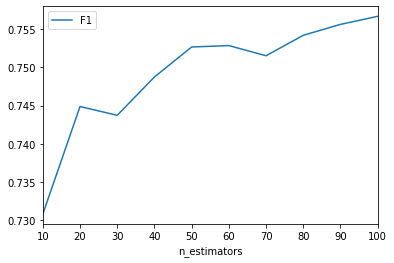

In [103]:
result.plot(x='n_estimators', y='F1')

In [104]:
%%time
# проверим модель  RandomForestClassifier с оптимальным параметром на тестовой выборке
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_tv, y_tv) 
predicted = model.predict(X_test)
print('f1_score = ', f1_score(y_test, predicted))

f1_score =  0.7559808612440191
CPU times: user 9min 17s, sys: 477 ms, total: 9min 17s
Wall time: 9min 23s


In [105]:
%%time
# Обучим модель CatBoost с параметрами по умолчанию  на тестовой выборке
model = CatBoostClassifier()
model.fit(X_tv, y_tv, verbose=False)
predicted = model.predict(X_test)
print('f1_score = ', f1_score(y_test, predicted))

f1_score =  0.7504387504387504
CPU times: user 58min 41s, sys: 58.3 s, total: 59min 40s
Wall time: 59min 51s


# 3. Выводы

### В проекте была произведена лемматизация текста, а затем его векторизация и TF-IDF. После этого были обученны модели с целью классификации комметариев на позитивные и негативные. Наиболее быстро работающей моделью оказалась логистическая регрессия с  оценкой по метрике f-1 score  равном 0.755. Модель случайного леса отработала за 8 минут и показала результат  f-1 score равным 0.759. Модель CatBoost,  f-1 score равен 0.75, но время работы составило около 1 часа. В целом, исходя из минимального требования - значением метрики качества F1 не меньше 0.75, можно предложить логистическую регрессию как наиболее быстрый и наименее затратный к ресурсам. 